In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import interp
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
%matplotlib inline
from sklearn.cross_validation import cross_val_score

In [2]:
dta = pd.read_csv("Bank Marketing FULL.csv")
dta.dropna()

print(dta.shape)

(41188, 21)


In [3]:
df = pd.get_dummies(dta)
print(df.shape)

(41188, 65)


In [4]:
df.ix[df.pdays == 999, 'pdays'] = 0
# 'pdays' = 999 means the client was not previously contacted about a campaign
# all 999 values were changed to 0

In [5]:
# dropping default categories for new dummy data set
col_drop = ['duration',
        'job_unemployed',
        'marital_single',
        'education_high.school',
        'default_no',
        'housing_no',
        'loan_no',
        'contact_telephone',
        'month_may', # range of contact months was March through December, most contact occurred during May.
        'day_of_week_fri',
        'poutcome_failure',
        'y_no']
dta_dummies = df.drop(df[col_drop], axis=1)
# 'y_yes' is outcome variable

dta_dummies.dropna()
dta_dummies['intercept'] = 1.0
print(dta_dummies.shape)
print(dta_dummies.columns)

(41188, 54)
Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unknown', 'marital_divorced',
       'marital_married', 'marital_unknown', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success

In [6]:
#train_cols = dta_dummies.columns[:52]
#print train_cols

train_cols = ['age',
              'campaign',
              'pdays',
              'previous',
              'emp.var.rate',
              'cons.price.idx',
              'cons.conf.idx',
              'euribor3m',
              'nr.employed',
              'job_admin.',
              'job_blue-collar',
              'job_entrepreneur',
              'job_housemaid',
              'job_management',
              'job_retired',
              'job_self-employed',
              'job_services',
              'job_student',
              'job_technician',
              'job_unknown',
              'marital_married',
              'marital_divorced',
              'marital_unknown',
              'education_basic.4y',
              'education_basic.6y',
              'education_basic.9y',
              'education_illiterate',
              'education_professional.course',
              'education_university.degree',
              'education_unknown',
              'default_yes',
              'default_unknown',
              'housing_yes',
              'housing_unknown',
              'loan_yes',
              'loan_unknown',
              'contact_cellular',
              'month_mar',
              'month_apr',
              'month_jun',
              'month_jul',
              'month_aug',
              'month_sep',
              'month_oct',
              'month_nov',
              'month_dec',
              'day_of_week_mon',
              'day_of_week_tue',
              'day_of_week_wed',
              'day_of_week_thu',
              'poutcome_success',
              'poutcome_nonexistent',
              'intercept']
              

In [8]:
# FEATURE SELECTION prior to LR, regularization afterwards

In [ ]:
# Recursive Feature Selection with Cross Validation
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X = dta_dummies[train_cols]
y = dta_dummies['y_yes']
 
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 5),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig('RFECV.pdf')

In [8]:
# Basic LR model
model = LogisticRegression()
model = model.fit(dta_dummies[train_cols], dta_dummies['y_yes'])

print(model.score(dta_dummies[train_cols], dta_dummies['y_yes']))
print(dta_dummies['y_yes'].mean())
# Approx. 90% accuracy without optimization or cross validation, although with only ~11% of all clients having 
# purchased term deposits we could still have almost 90% accuracy by always predicting "No"." 

0.897979994173
0.11265417111780131


In [10]:
print(pd.DataFrame(zip(dta_dummies[train_cols], np.transpose(model.coef_))))
#    Examining the coefficients, we see that increases in the number of contacts performed for a client both during 
# and prior to the current campaign (the 'campaign' and 'previous' variables) correspond with decreases in the
# likelihood of purchase. Increases in the employment variation rate and Euribor 3 month rate (the reference interest
# rate published by the European Banking Federation) also logically correspond with decreases in purchase likelihood. 
# Demographically, customers with varying levels of "basic" education were less likely to purchase deposits as were
# customers with either personal or home loans or credit in default. The only professions with increased likelihood of
# purchase were retirees, students, and technicians. Obviously if the outcome of the previous marketing campaign was
# a success, the client was more likely to purchase a deposit as well.

TypeError: data argument can't be an iterator

In [12]:
# Model Evaluation with Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    dta_dummies[train_cols], 
    dta_dummies['y_yes'], 
    test_size=0.4, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

eval_model = LogisticRegression()
print(eval_model.fit(X_train, y_train))
print(eval_model.score(X_train, y_train))

(24712, 53) (16476, 53) (24712,) (16476,)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
0.898915506636


In [14]:
predictedTEST = eval_model.predict(X_test)
predictedTRAIN = eval_model.predict(X_train)
probs = eval_model.predict_proba(X_test) 

# The training and test sets performed about the same, ~89% accuracy, though the test set was 0.001 higher.
print(eval_model.score(X_test, y_test))
print(metrics.accuracy_score(y_test, predictedTEST)  )
print (metrics.classification_report(y_test, predictedTEST))
print (metrics.classification_report(y_train, predictedTRAIN))

0.89973294489
0.89973294489
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.95     14655
        1.0       0.64      0.22      0.32      1821

avg / total       0.88      0.90      0.88     16476

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.95     21893
        1.0       0.66      0.23      0.34      2819

avg / total       0.88      0.90      0.88     24712



Confusion Matrix, without Normalization
[[14431   224]
 [ 1428   393]]
Normalized Confusion Matrix
[[ 0.98  0.02]
 [ 0.78  0.22]]


/Users/matthewhagen/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


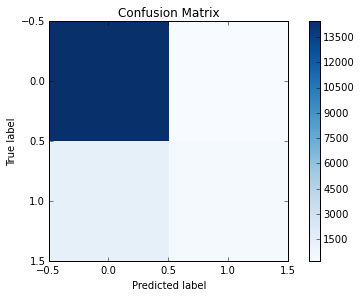

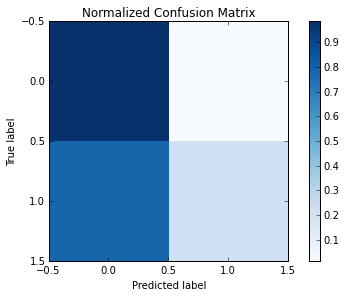

0.775612490166


In [16]:
# Confusion matrix for test set with corresponding AUC score
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictedTEST)

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)
print('Confusion Matrix, without Normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.savefig('CM.pdf')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')
plt.savefig('CMnorm.pdf')
plt.show()

print(metrics.roc_auc_score(y_test, probs[:, 1]))

In [25]:
#Used F2 score which favors recall and class weight parameters to show predictions can be improved 
#and minimize the amount of False Negatives, because even though the accuracy is high you have very low recall
#Recall = TP / (TP+FN)
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV
import math

def f_beta_score(beta,cm):
    betapow = math.pow(beta,2)
    numerator=(1+math.pow(beta,2))*cm[1,1]
    denominator=(1+betapow)*cm[1,1]+(betapow*cm[1,0])+cm[0,1]
    return numerator/denominator

param_grid = [                        
  {'class_weight':[{1:0.99,0:0.01},{1:0.95,0:0.05},{1:0.9,0:0.1},{1:0.8,0:0.2},{1:0.7,0:0.3},{1:0.6,0:0.4}]},
   ]

f2 = make_scorer(fbeta_score, beta=2)

grid_search = GridSearchCV(LogisticRegression(), cv=10,param_grid=param_grid, verbose=1,scoring=f2)

log_fitted=grid_search.fit(X_train,y_train).predict(X_test)

print("Best Weight Parameters: " + str(grid_search.best_params_))

print("Logistic Regression F2 score: %f" % fbeta_score(y_test,predictedTEST,2) )
print("Logistic Regression F2 score with class weight: %f" % fbeta_score(y_test,log_fitted,2))


print("Logistic Regression AUC score: %f" % metrics.roc_auc_score(y_test, predictedTEST))
print("Logistic Regression AUC score with class weight: %f" % metrics.roc_auc_score(y_test, log_fitted))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   10.2s


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Weight Parameters: {'class_weight': {0: 0.1, 1: 0.9}}
Logistic Regression F2 score: 0.248703
Logistic Regression F2 score with class weight: 0.529161
Logistic Regression AUC score: 0.600265
Logistic Regression AUC score with class weight: 0.732571


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   11.7s finished


Confusion Matrix, without Normalization
[[12096  2559]
 [  656  1165]]
Normalized Confusion Matrix
[[ 0.83  0.17]
 [ 0.36  0.64]]


/Users/matthewhagen/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


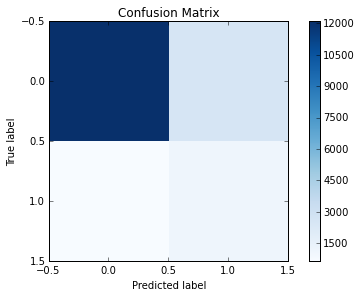

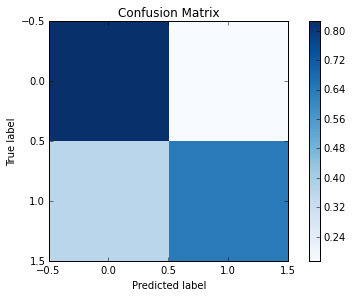

In [26]:
cmat=metrics.confusion_matrix(y_pred=log_fitted,y_true=y_test)

print('Confusion Matrix, without Normalization')
print(cmat)
plt.figure()
plot_confusion_matrix(cmat)

cmat_normalized = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix')
print(cmat_normalized)
plt.figure()
plot_confusion_matrix(cmat_normalized)



In [ ]:
#ROC curve with cross validation
#This would be the correcto 
conf_mat = np.zeros((2,2))
for i, (train,test) in enumerate(cv):
    dta_train = dta_dummies.iloc[train]
    dta_test = dta_dummies.iloc[test]
    y_predict = eval_model.fit(dta_train[train_cols],dta_train['y_yes']).predict(dta_test[train_cols])
    y_test = dta_test['y_yes']

    cm = confusion_matrix(y_test,y_predict)

    conf_mat = conf_mat + cm

print(conf_mat)

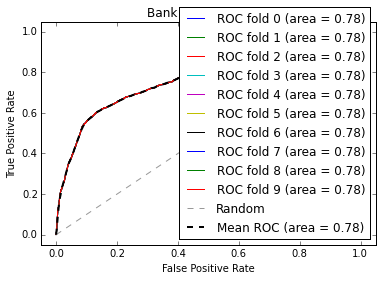

In [17]:
# ROC curve with cross validation
cv = StratifiedKFold(y_test, n_folds=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = eval_model.fit(X_train, y_train).predict_proba(X_test)
    cm = confusion_matrix(y_test, predictedTEST)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bank Marketing ROC')
plt.legend(loc="lower right")
plt.show()

In [27]:
#The code above is incorrect for cross validation, because it does not use the indexes returned train,test to split the dataset.
#Placed the correct crossvalidation code and confusion matrix below
cv = StratifiedKFold(y_test, n_folds=10)
conf_mat = np.zeros((2,2))
for i, (train,test) in enumerate(cv):
    dta_train = dta_dummies.iloc[train]
    dta_test = dta_dummies.iloc[test]
    y_predict = eval_model.fit(dta_train[train_cols],dta_train['y_yes']).predict(dta_test[train_cols])
    y_test = dta_test['y_yes']

    cm = confusion_matrix(y_test,y_predict)

    conf_mat = conf_mat + cm

print(conf_mat)

[[ 15770.      0.]
 [   706.      0.]]


In [ ]:
scores = cross_val_score(model, 
                         dta_dummies[train_cols], 
                         dta_dummies['y_yes'], 
                         scoring='accuracy', cv=8)
print scores.mean()
# With cross validation we see the model performing at 82% accuracy, which is pretty good in the employment 
# of direct marketing where costs of missclassification (calling the wrong person) are low.

In [ ]:
# With 5 folds the mean AUC is 0.77, a score which can definitely be improved through increased 
# analysis of the actual responders and the respective attributes that had the strongest affect on the successful
# outcome. It should be noted that all folds had the same AUC. 

In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge

clf = Ridge(alpha=0.2)
print clf.fit(dta_dummies[train_cols], dta_dummies['y_yes'])
print clf.score(dta_dummies[train_cols], dta_dummies['y_yes'])
#RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, 
                #max_iter=None, tol=0.001, class_weight=None, solver='auto', random_state=None)

In [ ]:
# Lasso Regression
from sklearn.linear_model import Lasso

clf = Lasso(alpha=0.2)
print clf.fit(dta_dummies[train_cols], dta_dummies['y_yes'])
print clf.score(dta_dummies[train_cols], dta_dummies['y_yes'])